## Seasonality

A very common feature in time series, especially in economics and weather are repeating patterns of 
higher or lower values over fixed periods of time.

Very often, economic activity is related to the time of the year, e.g. retail sales around Christmas, 
or gas consumption in winter, agricultural production that varies with the seasons, etc.


Until now we have almost exclusively focused on the residuals, i.e. the part of the series that is not
part of a trend or a seasonal pattern.

In this part of the course, we will see two possible ways of accounting for seasonality and trends 
in the data.

## Classical Decomposition

Suppose that a time series is a sum of a trend, a seasonal component and a residual:

$$
y_t = T_t + S_t + e_t
$$


The following code generates a synthetic time series with a trend, a seasonal component (ignore the formula for now) and a residual:

$$
T_t = 2 + 0.5 t
$$

$$
S_t = \sum_{j=1}^{4} \alpha_j \cos\left(\frac{2\pi j t}{4}\right) + \beta_j \sin\left(\frac{2\pi j t}{4}\right)
$$

$$
e_t \sim N(0, 2^2)
$$

$$
y_t = T_t + S_t + e_t
$$

The seasonal pattern is repeated every 4 quarters with 

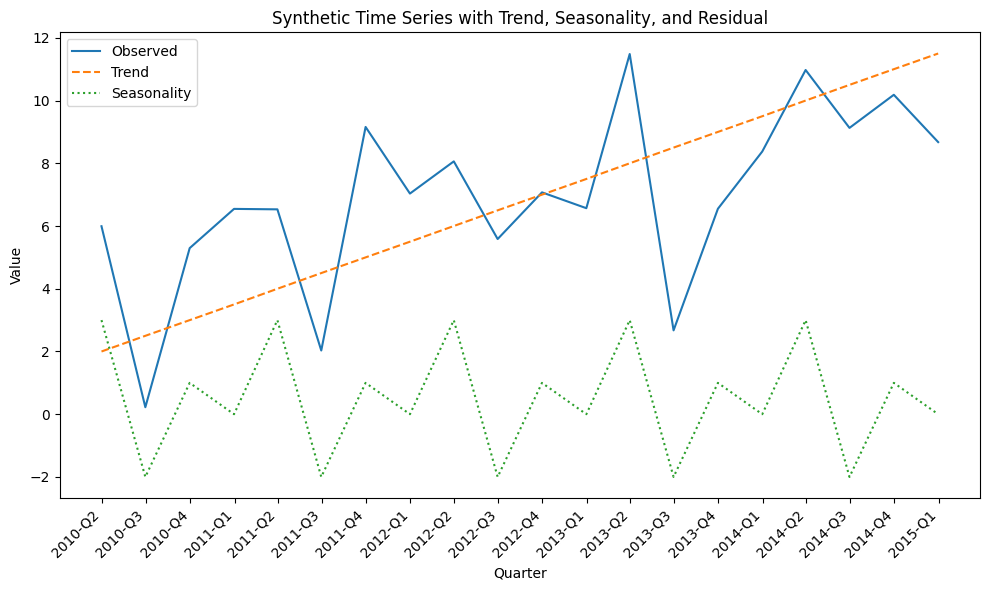

In [92]:
#| label: fig-trend-seasonality-residual
#| fig-label: "A synthetic time series with trend, seasonality, and residual"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Create a time index for 5 years of quarterly data
n_periods = 4 * 5  # 4 quarters per year, 5 years
t = np.arange(n_periods)

# Linear trend
trend = 2 + 0.5 * t

# Quarterly seasonality: repeat pattern every 4 steps
seasonal_pattern = np.array([3, -2, 1, 0])
seasonality = np.tile(seasonal_pattern, n_periods // 4)

# Residual/noise
np.random.seed(42)
residual = np.random.normal(loc=0.0, scale=2.0, size=n_periods)

# Combine to form the time series
y = trend + seasonality + residual

# Create DataFrame for convenience
dates = pd.date_range(start='2010-01-01', periods=n_periods, freq='QE')
df = pd.DataFrame({'y': y, 'trend': trend, 'seasonality': seasonality, 'residual': residual}, index=dates)

# Plot
plt.figure(figsize=(10,6))
plt.plot(df.index, df['y'], label='Observed')
plt.plot(df.index, df['trend'], label='Trend', linestyle='--')
plt.plot(df.index, df['seasonality'], label='Seasonality', linestyle='dotted')
plt.legend()
plt.title('Synthetic Time Series with Trend, Seasonality, and Residual')
plt.xlabel('Quarter')
plt.ylabel('Value')

# Format x-axis to show quarters
ax = plt.gca()

# Create custom formatter for quarters
def quarter_formatter(x, pos):
    date = mdates.num2date(x)
    quarter = (date.month - 1) // 3 + 1
    return f'{date.year}-Q{quarter}'

ax.xaxis.set_major_formatter(FuncFormatter(quarter_formatter))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Moving Average Smoothing

One way to capture the trend and seasonality is to use a moving average to create a new, smoothed series. The moving average takes a window of 2m values
before $t$, the value of at $t$ itself and the next 2m values after $t$. For odd values of $m$, for example $m=7$ (7 days in a week), the window will be 7 values.

$$
y_{t,m=7} = \frac{1}{2k+1} \sum_{j=-k}^{k} y_{t+j}
$$

and $m = 2k + 1$

$$
y_{t,m=7} = \frac{1}{7} \left( y_{t-3} + y_{t-2} + y_{t-1} + y_{t} + y_{t+1} + y_{t+2} + y_{t+3} \right)
$$

or with concrete numbers:

$$
y_{W1,Mo,m=7} = \frac{1}{7} \left( y_{W1,Fri} + y_{W2,Sat} + y_{W1,Sun} + y_{W2,Mo} + y_{W2,Tu} + y_{W2,We} + y_{W2,Th} \right)
$$

For example, for quarterly data, a moving average with a window of 4 will take the average of the current quarter and the three previous and following quarters.

$$
y_{t,m=4} = \frac{1}{4} \left( y_{t - 2} + y_{t - 1} + y_{t} + y_{t + 1} \right)
$$

or with concrete numbers:

$$
y_{2020Q1,m=4} = \frac{1}{4} \left( y_{2019Q3} + y_{2019Q4} + y_{2020Q1} + y_{2020Q2}\right)
$$

The problem with the last moving average is that it is not centered, because the window is not symmetric. A solution is to apply a moving average
of order 2 to the resulting moving average.

$$
y_{t,2 \times m=4} = \frac{1}{2} \left( y_{t,m=4} + y_{t+1,m=4} \right)
$$

Substituting $y_{t,m=4}$ and $y_{t+1,m=4}$ with their expression, we get:

$$
y_{t,2 \times m=4} = \frac{1}{2} \left( \frac{1}{4} \left( y_{t - 2} + y_{t - 1} + y_{t} + y_{t + 1} \right) + \frac{1}{4} \left( y_{t - 1} + y_{t} + y_{t + 1} + y_{t + 2} \right) \right)
$$

which simplifies when we arrange the terms:

$$
y_{t,2 \times m=4} =  \frac{1}{8} y_{t - 2} +  \frac{1}{4} y_{t - 1} +  \frac{1}{4} y_{t} +  \frac{1}{4} y_{t + 1} +  \frac{1}{8} y_{t + 2}
$$

which is a symmetric (weighted) average of 5 values.


Text(0.5, 1.0, 'Time Series with Moving Average')

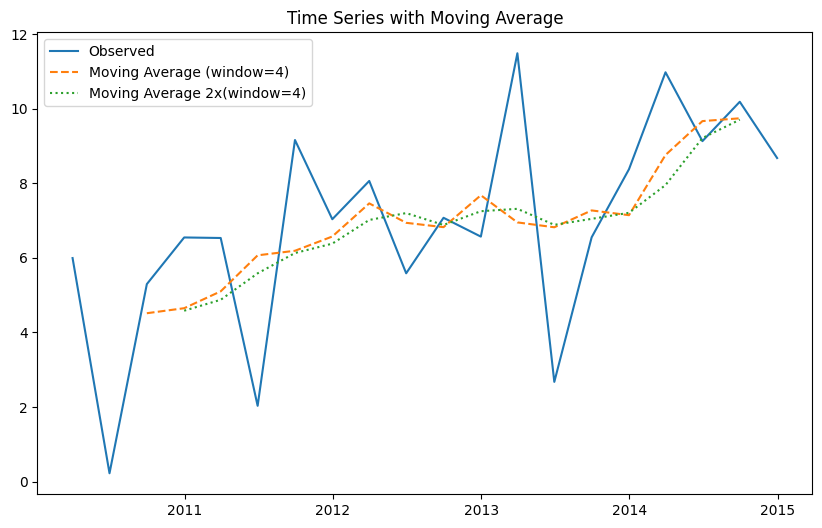

In [6]:
df["y_ma4"] = df["y"].rolling(window=4, center=True, min_periods=4).mean()
df["y_ma2x4"] = df["y_ma4"].rolling(window=2, center=True, min_periods=2).mean()

plt.figure(figsize=(10,6))
plt.plot(df.index, df['y'], label='Observed')
plt.plot(df.index, df['y_ma4'], label='Moving Average (window=4)', linestyle='--')
plt.plot(df.index, df['y_ma2x4'], label='Moving Average 2x(window=4)', linestyle='dotted')
plt.legend()

plt.title('Time Series with Moving Average')

## Removing the trend of the series

After we have estimated the trend using a moving average, we can remove it from the series.

$$
\hat{y}_{t,ma} = y_t - \hat{T}_t
$$


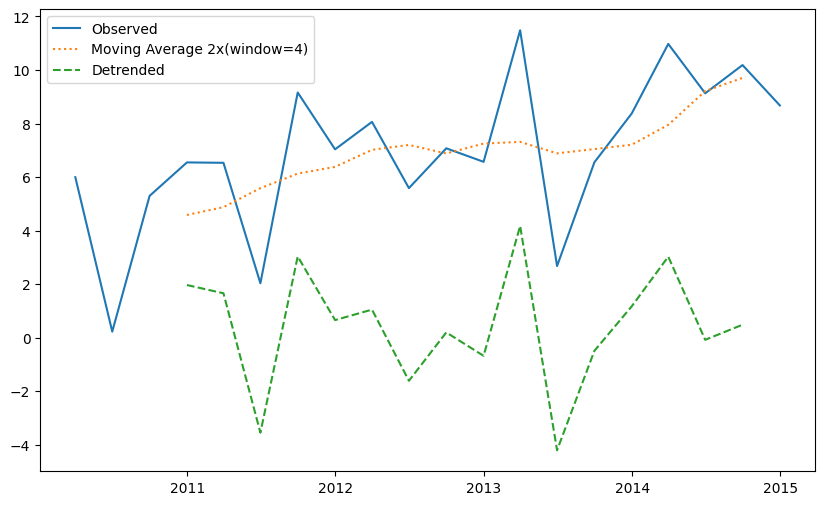

In [12]:
df["y_detrended"] = df["y"] - df["y_ma2x4"]

plt.figure(figsize=(10,6))
plt.plot(df.index, df['y'], label='Observed')
plt.plot(df.index, df['y_ma2x4'], label='Moving Average 2x(window=4)', linestyle='dotted')
plt.plot(df.index, df['y_detrended'], label='Detrended', linestyle='--')
plt.legend()


With the trend removed, we can see the seasonal pattern more clearly and estimate it. A simple 
way to do this is to take the average of the detrended series for each season. This means
grouping the data by the season and then taking the mean of the values in each group.

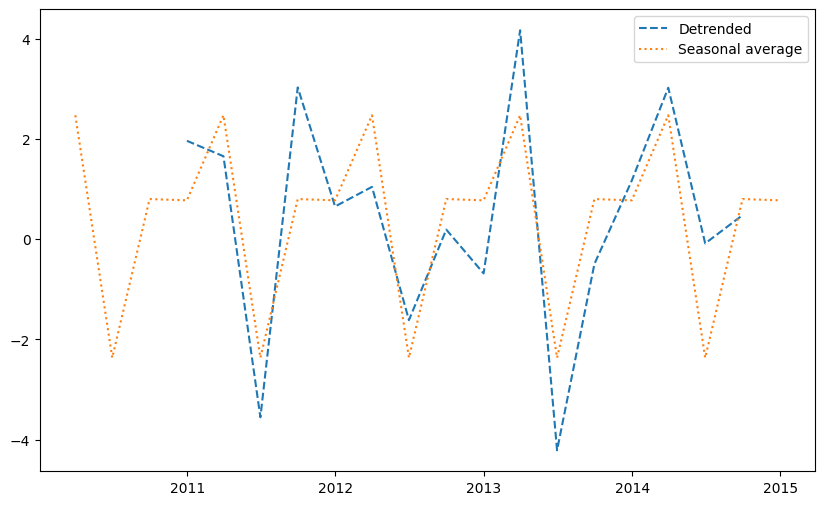

In [14]:
df["y_seasonal_avg"] = df.groupby(df.index.quarter)["y_detrended"].transform("mean")

plt.figure(figsize=(10,6))
plt.plot(df.index, df['y_detrended'], label='Detrended', linestyle='--')
plt.plot(df.index, df['y_seasonal_avg'], label='Seasonal average', linestyle='dotted')
plt.legend()

What remains is the residual, which is the part of the series that is not explained by the trend and the seasonality.

$$
\hat{e}_t = y_t - \hat{y}_{t,ma} - \hat{S}_t
$$

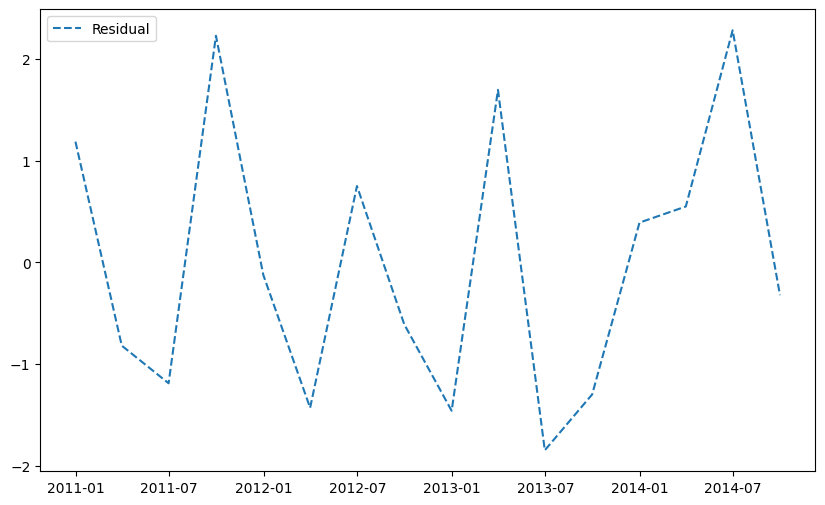

In [16]:
df["y_residual"] = df["y"] - df["y_ma2x4"] - df["y_seasonal_avg"]

plt.figure(figsize=(10,6))
plt.plot(df.index, df['y_residual'], label='Residual', linestyle='--')
plt.legend()
plt.show()

This classical approach is very simple and easy to understand, but it suffers from a number of problems.

1. Due to the moving average, the trend can not be estimated for the first and last $m/2$ values.
2. It is very sensitive to the presence of outliers.
3. It does not allow for time-varying seasonality.
4. It also does not allow for multiple seasonal patterns.


## A Review of Sine and Cosine Functions

Remember the sine and cosine functions and how they arise?


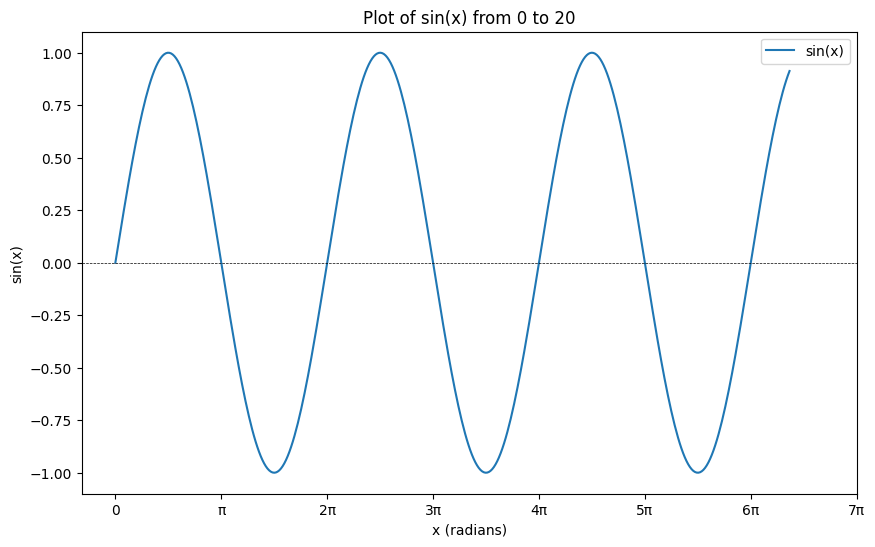

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

x = np.linspace(0, 20, 400)
y = np.sin(x)

plt.figure(figsize=(10,6))
plt.plot(x, y, label='sin(x)')
plt.title('Plot of sin(x) from 0 to 20')
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)

# Format x-axis labels as multiples of π
def pi_formatter(x_val, pos):
    """Format x-axis label as multiple of π"""
    pi_multiple = x_val / np.pi
    if abs(pi_multiple) < 0.01:
        return '0'
    elif abs(pi_multiple - 1) < 0.01:
        return 'π'
    elif abs(pi_multiple + 1) < 0.01:
        return '-π'
    elif abs(pi_multiple - 2) < 0.01:
        return '2π'
    elif abs(pi_multiple + 2) < 0.01:
        return '-2π'
    elif pi_multiple == int(pi_multiple):
        return f'{int(pi_multiple)}π'
    else:
        # Simplify common fractions
        from fractions import Fraction
        try:
            frac = Fraction(pi_multiple).limit_denominator(8)
            if frac.denominator == 1:
                return f'{frac.numerator}π'
            else:
                return f'{frac.numerator}π/{frac.denominator}'
        except:
            return f'{pi_multiple:.2f}π'

# Set tick locations at multiples of π
max_x = 20
tick_locations = np.arange(0, max_x + np.pi, np.pi)
plt.xticks(tick_locations)
plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
plt.xlabel('x (radians)')
plt.ylabel('sin(x)')
plt.legend()
plt.show()

It is convenient to express the sine function as a function of time $t$ and for now think about $t$ as seconds.

$$
f(t) = \sin(2\pi \textcolor{red}{f} \textcolor{blue}{t})
$$

The constant $f$ is called the angular frequency and it is easier to see what it does visually by plotting it for different values of $f$.

{{< video ./figures/AngularFrequencyDemo.mp4 >}}

In [53]:
import numpy as np
import plotly.graph_objects as go

# Generate a 2 kHz sine wave (audio rate)
fs = 44100  # Sample rate (Hz)
duration = 3
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
freq = 440  # frequency in Hz

y = np.sin(2 * np.pi * freq * t)

# Plot the sine wave using plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=t * 1000,
    y=y,
    mode='lines',
    name=f'{freq} Hz',
    line=dict(color='blue', width=1)
))

fig.update_layout(
    title=f"{freq} Hz Sine Wave",
    xaxis_title="Time (ms)",
    yaxis_title="Amplitude",
    xaxis=dict(range=[0, duration * 1000]),
    template="plotly_white",
    width=1000,
    height=400,
    showlegend=True
)

fig.show()

# Play the signal (in Jupyter, use Audio widget)
from IPython.display import Audio
Audio(y, rate=fs)


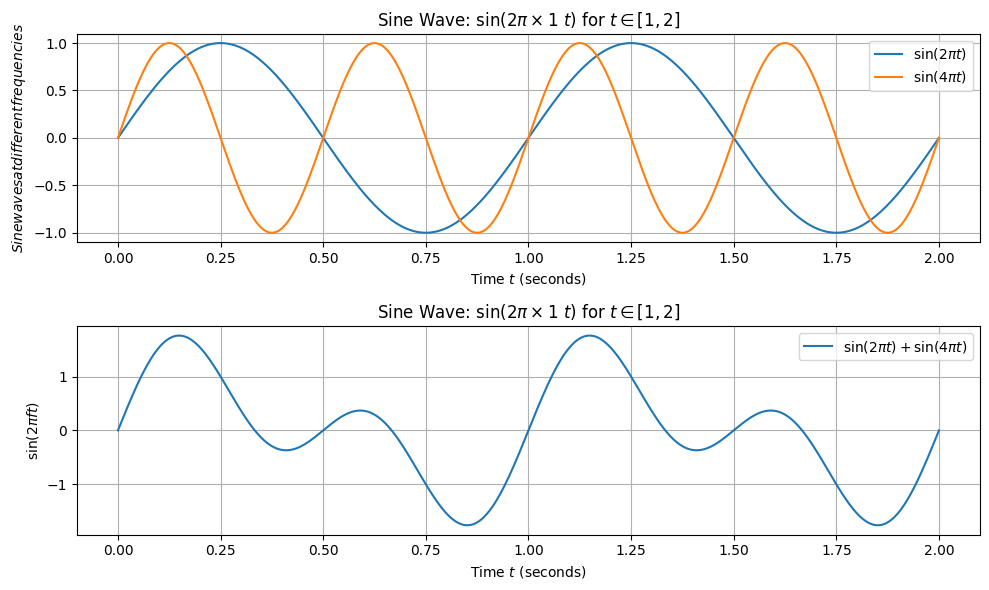

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Time vector from 0 to 2 seconds
t = np.linspace(0, 2, 500)
sine_wave_1 = np.sin(2 * np.pi * t) # f = 1 Hz
sine_wave_2 = np.sin(2 * np.pi * 2 * t) # f = 2 Hz


fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax[0].plot(t, sine_wave_1, label=fr'$\sin(2\pi t)$')
ax[0].plot(t, sine_wave_2, label=fr'$\sin(4\pi t)$')
ax[0].set_xlabel('Time $t$ (seconds)')
ax[0].set_ylabel(r'$Sine waves at different frequencies$')
ax[0].set_title(f"Sine Wave: $\\sin(2\\pi \\times {f} \\ t)$ for $t\\in[1,2]$")
ax[0].grid(True)
ax[0].legend()

ax[1].plot(t, sine_wave_1 + sine_wave_2, label=fr'$\sin(2\pi t) + \sin(4\pi t)$')
ax[1].set_xlabel('Time $t$ (seconds)')
ax[1].set_ylabel(r'$\sin(2\pi f t)$')
ax[1].set_title(f"Sine Wave: $\\sin(2\\pi \\times {f} \\ t)$ for $t\\in[1,2]$")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()


## How similar are two time series?

As a measure of similarity, we can use the cosine of the angle between two vectors.


{{< video ./figures/CosineSimilarity.mp4 >}}


Ok, given two vectors, e.g. $x = (x_1, x_2, \ldots, x_n)$ and $y = (y_1, y_2, \ldots, y_n)$, the cosine of the angle between them is given by:

$$
\cos(\theta) = \frac{x \cdot y}{\|x\| \|y\|} = \frac{\sum_{i=1}^{n} x_i y_i}{\sqrt{\sum_{i=1}^{n} x_i^2} \sqrt{\sum_{i=1}^{n} y_i^2}}
$$

As a small example, let's say we have two vectors $x = (1, 2, 3)$ and $y = (4, 5, 6)$. Then the cosine of the angle between them is:

$$
\cos(\theta) = \frac{1 \cdot 4 + 2 \cdot 5 + 3 \cdot 6}{\sqrt{1^2 + 2^2 + 3^2} \sqrt{4^2 + 5^2 + 6^2}} = \frac{32}{\sqrt{14} \sqrt{77}} \approx 0.94
$$


This is all fine, but if we have two sine waves, where do we get the vectors to apply this to? What we can do (and this is applicable also when we have a discrete time series) is to sample the functions at regular intervals and use the values as the components of the vector.

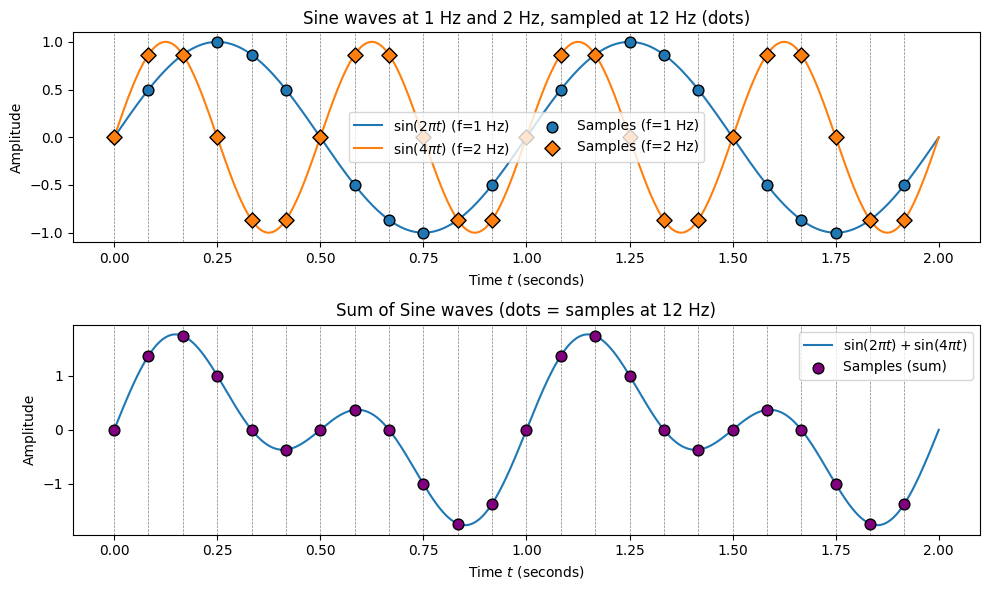

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set up parameters
fs = 12  # samples per second
duration = 2  # seconds
t = np.linspace(0, duration, int(duration * fs), endpoint=False)  # sampled times

freq1 = 1  # Hz
freq2 = 2  # Hz

sine1 = np.sin(2 * np.pi * freq1 * t)
sine2 = np.sin(2 * np.pi * freq2 * t)

t_dense = np.linspace(0, duration, 1000)
sine1_dense = np.sin(2 * np.pi * freq1 * t_dense)
sine2_dense = np.sin(2 * np.pi * freq2 * t_dense)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Plot continuous sine waves
ax[0].plot(t_dense, sine1_dense, label=r'$\sin(2\pi t)$ (f=1 Hz)')
ax[0].plot(t_dense, sine2_dense, label=r'$\sin(4\pi t)$ (f=2 Hz)')

# Plot samples as dots
ax[0].scatter(t, sine1, color='tab:blue', edgecolor='k', zorder=3, s=60, marker='o', label='Samples (f=1 Hz)')
ax[0].scatter(t, sine2, color='tab:orange', edgecolor='k', zorder=3, s=60, marker='D', label='Samples (f=2 Hz)')


ax[0].set_xlabel('Time $t$ (seconds)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title("Sine waves at 1 Hz and 2 Hz, sampled at 12 Hz (dots)")
ax[0].legend(ncol=2)
# ax[0].grid(True)

# Also show the sum and its samples
sum_dense = sine1_dense + sine2_dense
sum_samples = sine1 + sine2

ax[1].plot(t_dense, sum_dense, label=r'$\sin(2\pi t) + \sin(4\pi t)$')
ax[1].scatter(t, sum_samples, color='purple', edgecolor='k', zorder=3, s=60, marker='o', label='Samples (sum)')

ax[1].set_xlabel('Time $t$ (seconds)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title("Sum of Sine waves (dots = samples at 12 Hz)")
ax[1].legend()
# ax[1].grid(True)

for t_ in t:
    ax[0].axvline(x=t_, color='gray', linestyle='--', linewidth=0.5, zorder=1)
    ax[1].axvline(x=t_, color='gray', linestyle='--', linewidth=0.5, zorder=1)


plt.tight_layout()
plt.show()


In [55]:
import pandas as pd

# Create a DataFrame showing the sampled points
sampled_df = pd.DataFrame({
    't': t,
    'sine_1Hz': sine1,
    'sine_2Hz': sine2,
    'sum': sum_samples
})
sampled_df


t      sine_1Hz      sine_2Hz           sum
0   0.000000  0.000000e+00  0.000000e+00  0.000000e+00
1   0.083333  5.000000e-01  8.660254e-01  1.366025e+00
2   0.166667  8.660254e-01  8.660254e-01  1.732051e+00
3   0.250000  1.000000e+00  1.224647e-16  1.000000e+00
4   0.333333  8.660254e-01 -8.660254e-01  3.330669e-16
5   0.416667  5.000000e-01 -8.660254e-01 -3.660254e-01
6   0.500000  1.224647e-16 -2.449294e-16 -1.224647e-16
7   0.583333 -5.000000e-01  8.660254e-01  3.660254e-01
8   0.666667 -8.660254e-01  8.660254e-01  7.771561e-16
9   0.750000 -1.000000e+00  3.673940e-16 -1.000000e+00
10  0.833333 -8.660254e-01 -8.660254e-01 -1.732051e+00
11  0.916667 -5.000000e-01 -8.660254e-01 -1.366025e+00
12  1.000000 -2.449294e-16 -4.898587e-16 -7.347881e-16
13  1.083333  5.000000e-01  8.660254e-01  1.366025e+00
14  1.166667  8.660254e-01  8.660254e-01  1.732051e+00
15  1.250000  1.000000e+00  6.123234e-16  1.000000e+00
16  1.333333  8.660254e-01 -8.660254e-01  1.443290e-15
17  1.416667  5.000000e-01 -8.660254e-01 -3.660254e-01
18  1.500000  3.673940e-16 -7.347881e-16 -3.673940e-16
19  1.583333 -5.000000e-01  8.660254e-01  3.660254e-01
20  1.666667 -8.660254e-01  8.660254e-01  2.442491e-15
21  1.750000 -1.000000e+00  8.572528e-16 -1.000000e+00
22  1.833333 -8.660254e-01 -8.660254e-01 -1.732051e+00
23  1.916667 -5.000000e-01 -8.660254e-01 -1.366025e+00

In [ ]:
import numpy as np

# Calculate the dot product between the two sampled sine waves
dot_product = np.dot(sine1, sine2)

print(f"Dot product between sine1 and sine2: {dot_product:0.4f}")


Dot product between sine1 and sine2: 0.0000


Text(0.5, 1.0, 'Dot product between sampled sine waves at different frequencies')

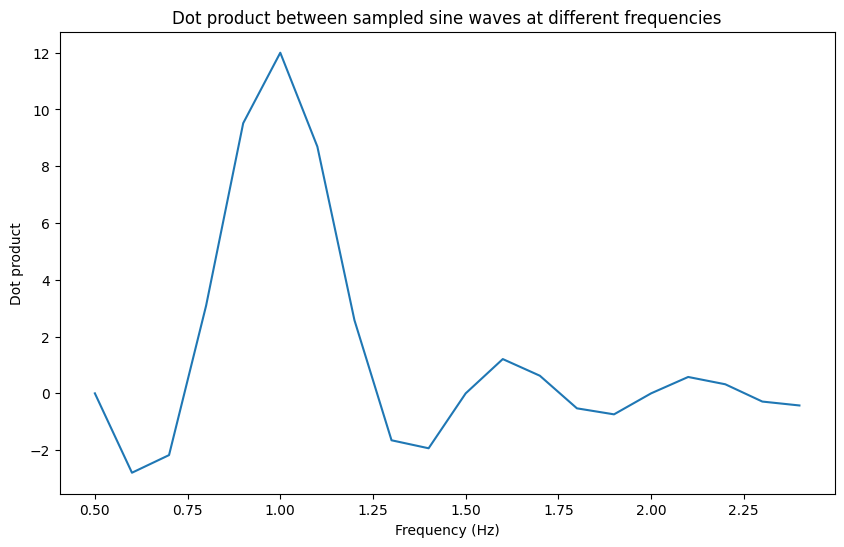

In [61]:
# Let's repeat this process for a range of frequencies: from f=0.5 to f=2.5 Hz, in steps of 0.1 Hz

import numpy as np
import matplotlib.pyplot as plt

# Set up parameters
fs = 12  # samples per second
duration = 2  # seconds
t = np.linspace(0, duration, int(duration * fs), endpoint=False)  # sampled times

freq_range = np.arange(0.5, 2.5, 0.1)  # from 0.5 to 2.5 Hz, in steps of 0.1 Hz

# Initialize lists to store results
dot_products = []
cosines = []

for freq in freq_range:
    # Generate sine waves
    sine1 = np.sin(2 * np.pi * 1 * t)
    sine2 = np.sin(2 * np.pi * freq * t)
    
    # Calculate dot product
    dot_product = np.dot(sine1, sine2)
    dot_products.append(dot_product)
    

# Now plot the results
plt.figure(figsize=(10, 6))
plt.plot(freq_range, dot_products, label='Dot product between sampled sine waves')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Dot product')
plt.title("Dot product between sampled sine waves at different frequencies")




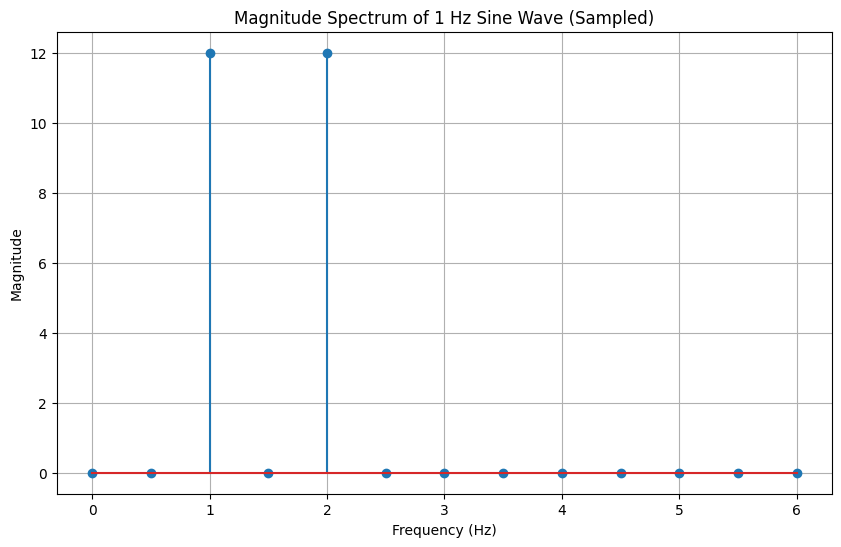

In [66]:
# Plot the magnitude spectrum of the 1 Hz sine wave using FFT

from numpy.fft import rfft, rfftfreq
fs = 12  # samples per second, same as above
N = len(t)
sine1 = np.sin(2 * np.pi * 1 * t)
sine2_sum = np.sin(2 * np.pi * 1 * t) + np.sin(2 * np.pi * 2 * t)

# Compute the FFT
spectrum = rfft(sine2_sum)
freqs = rfftfreq(N, 1/fs)

# Plot the spectrum
plt.figure(figsize=(10,6))
plt.stem(freqs, np.abs(spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum of 1 Hz Sine Wave (Sampled)')
plt.grid(True)
plt.show()


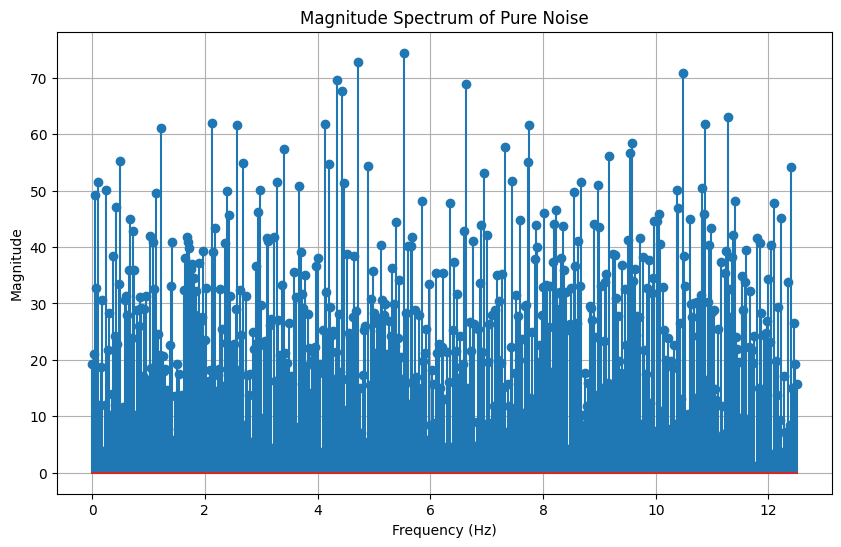

In [73]:
# Plot the magnitude spectrum of a pure noise process

np.random.seed(42)

N = 1000
fs = 25  # same as before

# Generate pure noise (white noise)
noise = np.random.normal(0, 1, N)

# Compute FFT
noise_spectrum = rfft(noise)
noise_freqs = rfftfreq(N, 1/fs)

# Plot the spectrum
plt.figure(figsize=(10, 6))
plt.stem(noise_freqs, np.abs(noise_spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum of Pure Noise')
plt.grid(True)
plt.show()


## Magnitude Spectrum of a Noisy Time Series

Let's take our first example and see what the magnitude spectrum looks like.

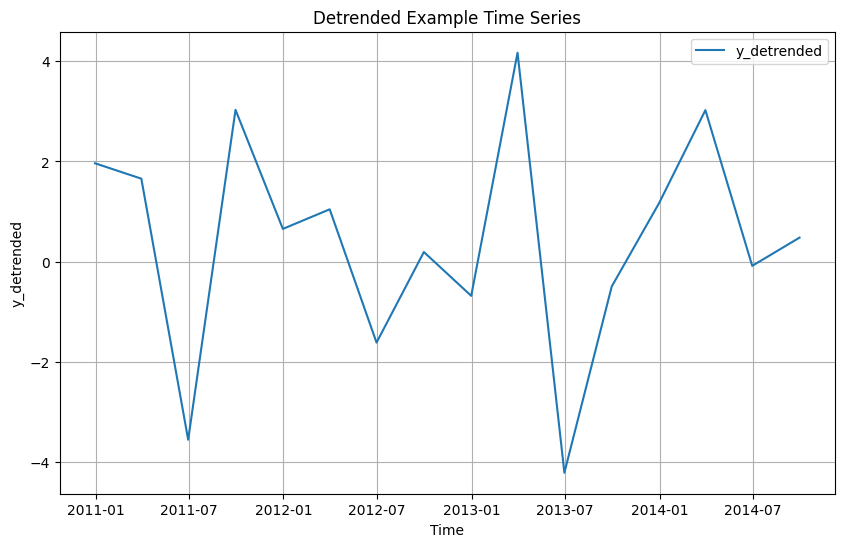

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["y_detrended"], label="y_detrended")
plt.xlabel("Time")
plt.ylabel("y_detrended")
plt.title("Detrended Example Time Series")
plt.legend()
plt.grid(True)
plt.show()


In [91]:
df["y_seasonal"]

2010-03-31    2.474045
2010-06-30   -2.365061
2010-09-30    0.802361
2010-12-31    0.776453
2011-03-31    2.474045
2011-06-30   -2.365061
2011-09-30    0.802361
2011-12-31    0.776453
2012-03-31    2.474045
2012-06-30   -2.365061
2012-09-30    0.802361
2012-12-31    0.776453
2013-03-31    2.474045
2013-06-30   -2.365061
2013-09-30    0.802361
2013-12-31    0.776453
2014-03-31    2.474045
2014-06-30   -2.365061
2014-09-30    0.802361
2014-12-31    0.776453
Freq: QE-DEC, Name: y_seasonal, dtype: float64

<Axes: >

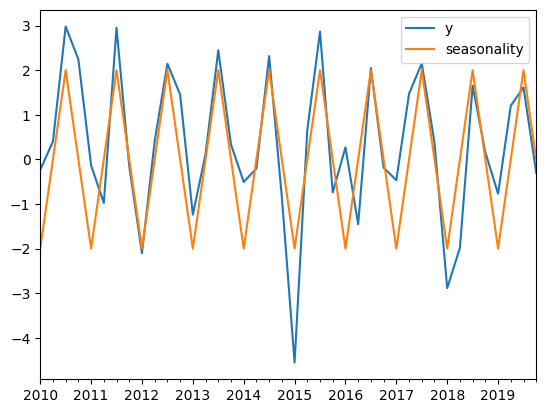

In [137]:
# Generate 10 years of quarterly data with seasonal pattern
import numpy as np
import pandas as pd

np.random.seed(0)
n_years = 10
n_periods = n_years * 4  # 4 quarters per year

# Create a date range for 10 years of quarterly observations
dates = pd.date_range(start="2010-01-01", periods=n_periods, freq="QE")

# Simulate a seasonal pattern: for quarter q, assign value sin(2 * pi * q/4)
# Use numpy tile/repeat to create seasonality repeating every 4 quarters
seasonal_pattern = np.tile([-2, 0, 2, 0], n_years)

# Add a little random noise
noise = np.random.normal(0, 1, n_periods)

# Compose the time series
y = seasonal_pattern + noise

# Store in DataFrame
quarterly_df = pd.DataFrame({"y": y, "seasonality": seasonal_pattern}, index=dates)

quarterly_df.plot()

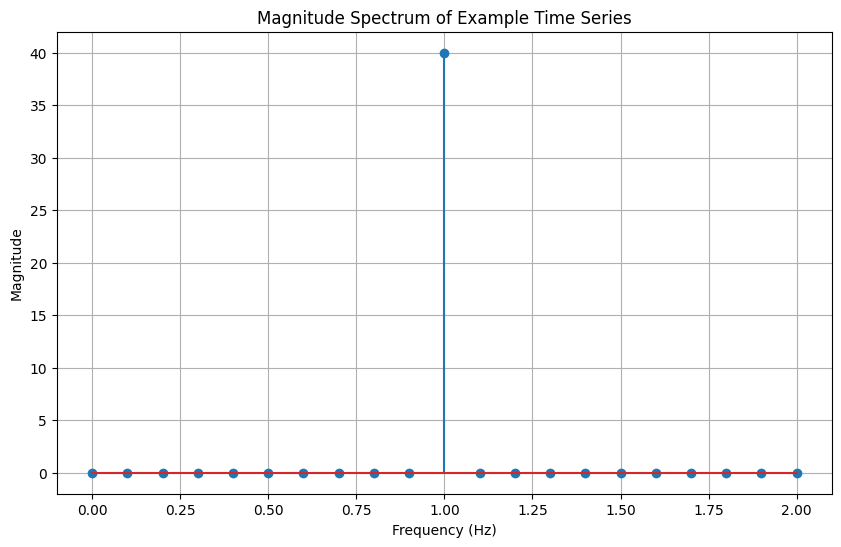

In [138]:
# Compute and plot the magnitude spectrum of the first example time series (y)

# y, fs were defined in the first example above: y is the time series, fs is the sampling frequency

from numpy.fft import rfft, rfftfreq

N = len(quarterly_df["y"])
spectrum = rfft(quarterly_df["seasonality"] - quarterly_df["seasonality"].mean())
freqs = rfftfreq(N, 1/ 4)

plt.figure(figsize=(10,6))
plt.stem(freqs, np.abs(spectrum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Magnitude Spectrum of Example Time Series')
plt.grid(True)
plt.show()


In [139]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier

# Create deterministic process with Fourier terms
fourier_terms = Fourier(period=4, order=1)  # period=m, order=p

dp = DeterministicProcess(
    index=quarterly_df.index,
    constant=True,  # Include intercept
    order=0,  # No polynomial trend (use order=1 for linear trend)
    additional_terms=[fourier_terms]
)
exog = dp.in_sample()
exog.head()

const      sin(1,4)      cos(1,4)
2010-03-31    1.0  0.000000e+00  1.000000e+00
2010-06-30    1.0  1.000000e+00  6.123234e-17
2010-09-30    1.0  1.224647e-16 -1.000000e+00
2010-12-31    1.0 -1.000000e+00 -1.836970e-16
2011-03-31    1.0 -2.449294e-16  1.000000e+00

In [140]:

# Get the exogenous variables automatically

# Fit ARIMA model
model = ARIMA(quarterly_df['y'], exog=exog, order=(0, 0, 0), trend='n')
results = model.fit()

print(results.summary())

# For forecasting
exog_future = dp.out_of_sample(steps=4)
forecast = results.forecast(steps=4, exog=exog_future)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:                          ARIMA   Log Likelihood                 -58.692
Date:                Tue, 16 Dec 2025   AIC                            125.385
Time:                        20:38:47   BIC                            132.140
Sample:                    03-31-2010   HQIC                           127.827
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3125      0.207      1.512      0.131      -0.093       0.718
sin(1,4)      -0.1343      0.257     -0.522      0.602      -0.639       0.370
cos(1,4)      -1.7892      0.287     -6.224      0.0

In [141]:
params = results.params
magnitude1 = np.sqrt(params.get('cos(1,4)', 0)**2 + params.get('sin(1,4)', 0)**2)
phase1 = np.arctan2(-params.get('sin(1,4)', 0), params.get('cos(1,4)', 0))

print(f"Magnitude of the first harmonic: {magnitude1:.4f}")
print(f"Phase shift of the first harmonic: {phase1:.4f} radians")


Magnitude of the first harmonic: 1.7942
Phase shift of the first harmonic: 3.0667 radians


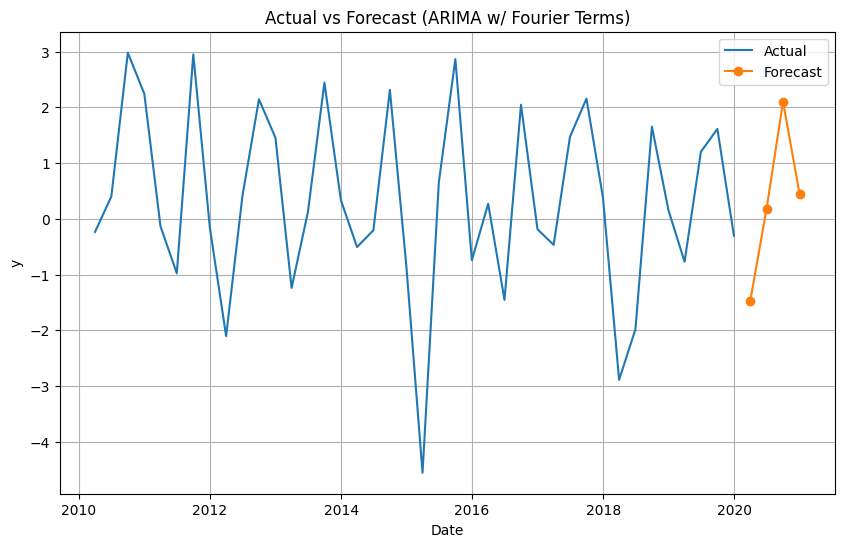

In [142]:
plt.figure(figsize=(10,6))
plt.plot(quarterly_df.index, quarterly_df['y'], label='Actual')
forecast_index = pd.date_range(start=quarterly_df.index[-1] + pd.tseries.offsets.QuarterEnd(), periods=4, freq='QE')
plt.plot(forecast_index, forecast, label='Forecast', marker='o')
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Actual vs Forecast (ARIMA w/ Fourier Terms)')
plt.legend()
plt.grid(True)
plt.show()


## Harmonic Regression

The harmonic regression is a simple extension of the classical decomposition that allows for time-varying seasonality as well as trends.

$$
y_t = \mu + \alpha t +  \sum_{j=1}^{p} \left( \alpha_j \cos\left(\frac{2\pi j t}{m}\right) + \beta_j \sin\left(\frac{2\pi j t}{m}\right) \right) + e_t, \quad e_t \sim ARIMA(p,d,q)
$$

### Understanding Fourier Terms

The **Fourier terms** in the harmonic regression are the sine and cosine components:

$$
\alpha_j \cos\left(\frac{2\pi j t}{m}\right) + \beta_j \sin\left(\frac{2\pi j t}{m}\right)
$$

These terms model seasonal patterns using trigonometric functions. Here's what each component means:

1. **$m$** - The seasonal period (e.g., $m=4$ for quarterly data, $m=12$ for monthly data, $m=365$ for daily data)

2. **$j$** - The harmonic number (frequency component). Each value of $j$ represents a different frequency:
   - $j=1$: The fundamental frequency (one complete cycle per seasonal period)
   - $j=2$: The second harmonic (two complete cycles per seasonal period)
   - $j=3$: The third harmonic (three complete cycles per seasonal period)
   - And so on...

3. **$\alpha_j$ and $\beta_j$** - Coefficients that determine the amplitude and phase of each harmonic component. These are estimated from the data.

4. **$\frac{2\pi j t}{m}$** - The argument of the trigonometric functions. This ensures that:
   - When $t$ increases by $m$, the argument increases by $2\pi j$, completing $j$ full cycles
   - The pattern repeats every $m$ time periods

**Why use both sine and cosine?**

A single sine or cosine function can only represent a wave with a specific phase (starting point). By combining both sine and cosine terms with different coefficients ($\alpha_j$ and $\beta_j$), we can represent any sinusoidal pattern with any phase and amplitude. This is equivalent to:

$$
\alpha_j \cos\left(\frac{2\pi j t}{m}\right) + \beta_j \sin\left(\frac{2\pi j t}{m}\right) = A_j \cos\left(\frac{2\pi j t}{m} + \phi_j\right)
$$

where $A_j = \sqrt{\alpha_j^2 + \beta_j^2}$ is the amplitude and $\phi_j = \arctan\left(\frac{-\beta_j}{\alpha_j}\right)$ is the phase shift.

**How many harmonics ($p$) to include?**

- For quarterly data ($m=4$), you typically need at most $p=2$ harmonics to capture the seasonal pattern
- For monthly data ($m=12$), you might use $p=6$ harmonics (though often fewer are needed)
- The number of harmonics determines how flexible the seasonal pattern can be. More harmonics allow for more complex patterns, but also increase the risk of overfitting.



